# Zielsetzung:

Das Ziel dieses Projekts ist es, ein Machine-Learning-Modell mit TensorFlow zu erstellen, um Aktienkurse vorherzusagen. Wir werden:

### Teil 1: Er stellen eine Machine Learning Modells zur Vorhersage des Aktienmarktes

> 1. __Aktienmarktdaten__ mit __Yahoo Finance__ abrufen. <br>
> 2.__Pandas__ verwenden, um die Daten zu speichern und vorzuverarbeiten. <br>
> 3.Ein __Deep-Learning-Modell__ mit TensorFlow trainieren, um Aktienkurse vorherzusagen.<br>
> 4.Die Ergebnisse mit __Matplotlib__ visualisieren. <br>

### Teil 2: Vergleich von LSTM, GRU und 1D-CNN Modellen zur Aktienkursvorhersage
>1.Modelltraining für jedes der Modelle <br>
>2.Performancevergleich mit 5 Metriken <br>
    &emsp;&emsp;    -Mean Squared Error (MSE) <br>
    &emsp;&emsp;    -Root Mean Squared Error (RMSE) <br>
    &emsp;&emsp;    -Mean Absolute Error (MAE) <br>
    &emsp;&emsp;    -R² (Bestimmtheitsmaß) <br>
    &emsp;&emsp;    -Mean Absolute Percentage Error (MAPE) <br>
>3.Visualisierung der Ergebnisse. <br>

### Teil 3: Statistische Analyse der Modelle
>1.Residualanalyse <br>
>2.Bland-Altman-Analyse <br>
>3.Likelihood Ratio Test <br>
>4.Shapiro-Wilk-Test <br>
>5.Cross-Validation / ANOVA <br> 

# Teil 1: Er stellen eine Machine Learning Modells zur Vorhersage des Aktienmarktes

## 1. Datenerfassung von Yahoo Finance

In [2]:
import yfinance as yf
import pandas as pd
import scipy

# Definiere das Aktien-Symbol (z.B. AAPL für Apple)
aktien_symbol = 'AAPL'

# Lade Aktienmarktdaten von Yahoo Finance (z.B. die letzten 5 Jahre)
aktien_daten = yf.download(aktien_symbol, start='2018-01-01', end='2023-01-01')

# Zeige die ersten Zeilen der Daten
print(aktien_daten.head())

# Speichere die Daten in einem Pandas DataFrame
aktien_daten.to_csv(f'{aktien_symbol}_aktien_daten.csv')

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-01-02  42.540001  43.075001  42.314999  43.064999  40.568928  102223600
2018-01-03  43.132500  43.637501  42.990002  43.057499  40.561867  118071600
2018-01-04  43.134998  43.367500  43.020000  43.257500  40.750275   89738400
2018-01-05  43.360001  43.842499  43.262501  43.750000  41.214237   94640000
2018-01-08  43.587502  43.902500  43.482498  43.587502  41.061153   82271200


Die Daten enthalten wichtige Spalten wie:

    Open: Eröffnungskurs der Aktie.
    High: Höchstkurs des Tages.
    Low: Tiefstkurs des Tages.
    Close: Schlusskurs der Aktie.
    Volume: Handelsvolumen (Anzahl der gehandelten Aktien).

## 2. Datenvorverarbeitung mit Pandas

Um die Daten für das Machine Learning vorzubereiten, werden wir sie bereinigen und Sequenzen erstellen, um ein Zeitreihenmodell zu trainieren.
Schritte:

    Fehlende Werte behandeln.
    Daten skalieren, um sie zu normalisieren (da LSTM-Modelle von skalierten Daten profitieren).
    Sequenzen historischer Datenpunkte erstellen, um den nächsten Wert vorherzusagen.
__LSTM-Modell__

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Fehlende Werte entfernen
aktien_daten = aktien_daten.dropna()

# Verwende nur die 'Close'-Preise für die Vorhersage
schlusskurse = aktien_daten['Close'].values
schlusskurse = schlusskurse.reshape(-1, 1)

# Daten auf den Bereich [0,1] skalieren
scaler = MinMaxScaler(feature_range=(0, 1))
skalierte_daten = scaler.fit_transform(schlusskurse)

# Sequenzen für das Modell erstellen
def erstelle_sequenzen(daten, sequenzlänge):
    sequenzen = []
    labels = []
    for i in range(len(daten) - sequenzlänge):
        sequenzen.append(daten[i:i + sequenzlänge])
        labels.append(daten[i + sequenzlänge])
    return np.array(sequenzen), np.array(labels)

# Definiere die Sequenzlänge (z.B. 60 Tage)
sequenzlänge = 60
X, y = erstelle_sequenzen(skalierte_daten, sequenzlänge)

# Aufteilen in Trainings- und Testdaten (80% Training, 20% Test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f'Trainingsdaten-Form: {X_train.shape}, Testdaten-Form: {X_test.shape}')

Trainingsdaten-Form: (959, 60, 1), Testdaten-Form: (240, 60, 1)


## 3. Modelltraining mit TensorFlow

Wir verwenden ein LSTM (Long Short-Term Memory)-Modell, das häufig für Zeitreihenvorhersagen eingesetzt wird, da es sich an langfristige Abhängigkeiten erinnern kann.
Modellarchitektur:

    LSTM-Schichten zur Verarbeitung sequentieller Daten.
    Dense-Schichten für die Regression zur Vorhersage von Aktienpreisen.

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# LSTM-Modell
lstm_modell = Sequential()

lstm_modell.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_modell.add(Dropout(0.2))

lstm_modell.add(LSTM(units=50, return_sequences=False))
lstm_modell.add(Dropout(0.2))

lstm_modell.add(Dense(units=1))

# Kompilieren des Modells
lstm_modell.compile(optimizer='adam', loss='mean_squared_error')

# Trainieren des Modells
lstm_history = lstm_modell.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

C:\Users\S-Lei\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0836 - val_loss: 0.0044
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0022 - val_loss: 0.0064
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# LSTM-Modell
lstm_modell = Sequential()

# Eingabeschicht hinzufügen
lstm_modell.add(Input(shape=(X_train.shape[1], 1)))

# LSTM- und Dropout-Schichten hinzufügen
lstm_modell.add(LSTM(units=50, return_sequences=True))
lstm_modell.add(Dropout(0.2))

lstm_modell.add(LSTM(units=50, return_sequences=False))
lstm_modell.add(Dropout(0.2))

# Ausgangsebene
lstm_modell.add(Dense(units=1))

# Kompilieren des Modells
lstm_modell.compile(optimizer='adam', loss='mean_squared_error')

# Trainieren des Modells
lstm_history = lstm_modell.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0493 - val_loss: 0.0036
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0

Modellzusammenfassung:

    LSTM-Schichten erfassen zeitliche Abhängigkeiten in den Daten.
    Dropout-Schichten helfen, Overfitting zu verhindern.
    Das Modell wird mit dem Adam-Optimierer und Mean Squared Error (MSE) als Verlustfunktion kompiliert.

## 4. Visualisierung der Ergebnisse mit Matplotlib

Nach dem Training des Modells können wir visualisieren, wie gut es die Aktienkurse auf den Testdaten vorhersagt.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


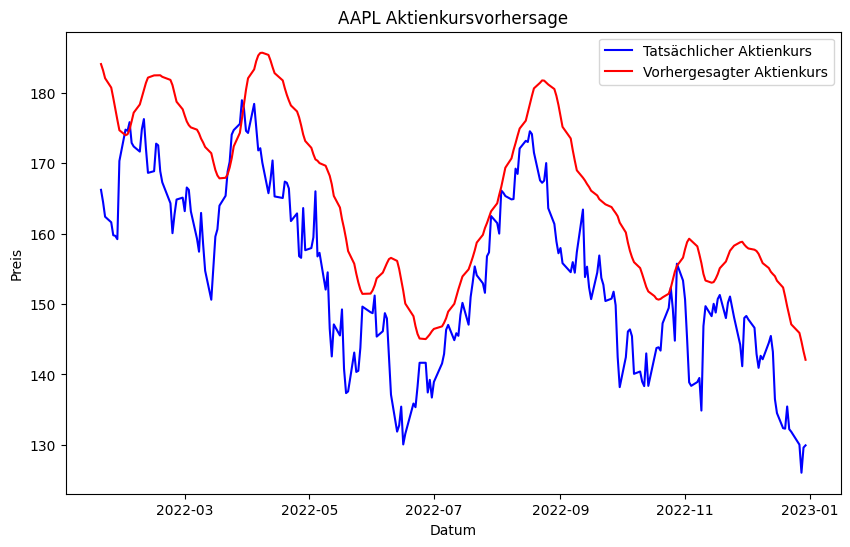

In [6]:
import matplotlib.pyplot as plt

# Vorhersage auf den Testdaten
vorhergesagte_preise = lstm_modell.predict(X_test)

# Skalierung rückgängig machen
vorhergesagte_preise = scaler.inverse_transform(vorhergesagte_preise)
wahre_preise = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ergebnisse plotten
plt.figure(figsize=(10, 6))
plt.plot(aktien_daten.index[-len(wahre_preise):], wahre_preise, color='blue', label='Tatsächlicher Aktienkurs')
plt.plot(aktien_daten.index[-len(vorhergesagte_preise):], vorhergesagte_preise, color='red', label='Vorhergesagter Aktienkurs')
plt.title(f'{aktien_symbol} Aktienkursvorhersage')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()
plt.show()

Dieses Diagramm zeigt den Vergleich zwischen den tatsächlichen Aktienkursen und den vorhergesagten Aktienkursen, sodass wir die Modellleistung visuell beurteilen können.

## 5. Evaluierung der Modellleistung

Um die Leistung des Modells zu quantifizieren, berechnen wir den Mean Squared Error (MSE) zwischen den vorhergesagten Preisen und den tatsächlichen Preisen.

In [7]:
from sklearn.metrics import mean_squared_error

# Mean Squared Error berechnen
mse = mean_squared_error(wahre_preise, vorhergesagte_preise)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 159.29635048548553


# Teil 2: Vergleich von LSTM, GRU und 1D-CNN Modellen zur Aktienkursvorhersage

__Übersicht__
Datenerfassung und Vorverarbeitung (identisch zum vorherigen Abschnitt).
Modelle:

    LSTM-Modell
    GRU-Modell
    Kombination aus 1D-CNN und LSTM

Modelltraining für jedes der Modelle.
Performancevergleich mit 5 Metriken:

    Mean Squared Error (MSE)
    Root Mean Squared Error (RMSE)
    Mean Absolute Error (MAE)
    R² (Bestimmtheitsmaß)
    Mean Absolute Percentage Error (MAPE)

Visualisierung der Ergebnisse.

__GRU-Modell__

Das GRU-Modell ist eine Alternative zum LSTM, die oft schneller trainiert, da weniger komplex. Wir implementieren hier ein GRU-Modell:

In [8]:
from tensorflow.keras.layers import GRU

# GRU-Modell
gru_modell = Sequential()

gru_modell.add(Input(shape=(X_train.shape[1], 1)))

gru_modell.add(GRU(units=50, return_sequences=True))
gru_modell.add(Dropout(0.2))

gru_modell.add(GRU(units=50, return_sequences=False))
gru_modell.add(Dropout(0.2))

gru_modell.add(Dense(units=1))

# Kompilieren des Modells
gru_modell.compile(optimizer='adam', loss='mean_squared_error')

# Trainieren des Modells
gru_history = gru_modell.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0746 - val_loss: 0.0179
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0051 - val_loss: 0.0016
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0

__Kombiniertes 1D-CNN und LSTM-Modell__

In diesem Modell kombinieren wir ein 1D-CNN (Convolutional Layer) zur Extraktion von Merkmalen mit einem LSTM, um Zeitabhängigkeiten zu erfassen.

In [9]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# 1D-CNN und LSTM Modell
cnn_lstm_modell = Sequential()

cnn_lstm_modell.add(Input(shape=(X_train.shape[1], 1)))

# 1D Convolutional Layer
cnn_lstm_modell.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_lstm_modell.add(MaxPooling1D(pool_size=2))

# LSTM Layer
cnn_lstm_modell.add(LSTM(units=50, return_sequences=False))
cnn_lstm_modell.add(Dropout(0.2))

# Dense Layer zur Vorhersage
cnn_lstm_modell.add(Dense(units=1))

# Kompilieren des Modells
cnn_lstm_modell.compile(optimizer='adam', loss='mean_squared_error')

# Trainieren des Modells
cnn_lstm_history = cnn_lstm_modell.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0513 - val_loss: 0.0031
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

## 3. Performancebewertung und Vergleich

Wir vergleichen die Modelle mit den folgenden Metriken:

    Mean Squared Error (MSE): Gibt die durchschnittliche quadratische Differenz zwischen den vorhergesagten und den tatsächlichen Werten an.
    Root Mean Squared Error (RMSE): Die Quadratwurzel des MSE; interpretiert in den gleichen Einheiten wie die Zielvariable.
    Mean Absolute Error (MAE): Der durchschnittliche absolute Fehler.
    R² (Bestimmtheitsmaß): Ein Maß dafür, wie gut die Vorhersagen mit den tatsächlichen Werten übereinstimmen.
    Mean Absolute Percentage Error (MAPE): Der durchschnittliche prozentuale Fehler.

__Evaluierung der Modelle:__

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Berechnung der Metriken für jedes Modell
def evaluierung(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, r2, mape

# Vorhersagen für LSTM
lstm_pred = lstm_modell.predict(X_test)
lstm_mse, lstm_rmse, lstm_mae, lstm_r2, lstm_mape = evaluierung(y_test, lstm_pred)

# Vorhersagen für GRU
gru_pred = gru_modell.predict(X_test)
gru_mse, gru_rmse, gru_mae, gru_r2, gru_mape = evaluierung(y_test, gru_pred)

# Vorhersagen für CNN-LSTM
cnn_lstm_pred = cnn_lstm_modell.predict(X_test)
cnn_lstm_mse, cnn_lstm_rmse, cnn_lstm_mae, cnn_lstm_r2, cnn_lstm_mape = evaluierung(y_test, cnn_lstm_pred)

# Ergebnisse anzeigen
print(f"LSTM-Modell: MSE={lstm_mse}, RMSE={lstm_rmse}, MAE={lstm_mae}, R2={lstm_r2}, MAPE={lstm_mape}")
print(f"GRU-Modell: MSE={gru_mse}, RMSE={gru_rmse}, MAE={gru_mae}, R2={gru_r2}, MAPE={gru_mape}")
print(f"CNN-LSTM-Modell: MSE={cnn_lstm_mse}, RMSE={cnn_lstm_rmse}, MAE={cnn_lstm_mae}, R2={cnn_lstm_r2}, MAPE={cnn_lstm_mape}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM-Modell: MSE=0.007425971036580822, RMSE=0.08617407403959047, MAE=0.07521690968395678, R2=-0.004243849453566817, MAPE=9.612175309826029
GRU-Modell: MSE=0.0017602567975898444, RMSE=0.04195541440135998, MAE=0.03441557197811813, R2=0.7619534127280467, MAPE=4.385284151734283
CNN-LSTM-Modell: MSE=0.001556361744911492, RMSE=0.03945075087893121, MAE=0.03270205540735527, R2=0.7895269585414608, MAPE=4.060173519598981


## 4. Visualisierung der Ergebnisse

Um die Vorhersagen jedes Modells zu visualisieren, können wir die tatsächlichen und vorhergesagten Aktienkurse nebeneinander darstellen.

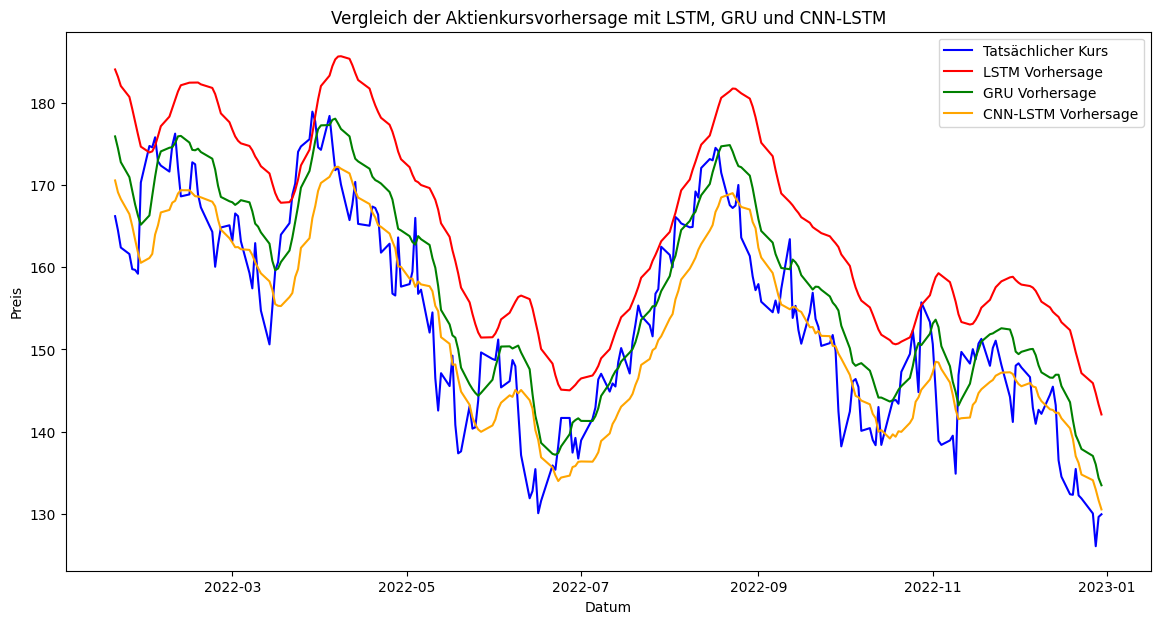

In [11]:
import matplotlib.pyplot as plt

# Visualisierung der Vorhersagen für LSTM, GRU und CNN-LSTM
plt.figure(figsize=(14, 7))

plt.plot(aktien_daten.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Tatsächlicher Kurs')

# LSTM Vorhersagen
plt.plot(aktien_daten.index[-len(lstm_pred):], scaler.inverse_transform(lstm_pred), color='red', label='LSTM Vorhersage')

# GRU Vorhersagen
plt.plot(aktien_daten.index[-len(gru_pred):], scaler.inverse_transform(gru_pred), color='green', label='GRU Vorhersage')

# CNN-LSTM Vorhersagen
plt.plot(aktien_daten.index[-len(cnn_lstm_pred):], scaler.inverse_transform(cnn_lstm_pred), color='orange', label='CNN-LSTM Vorhersage')

plt.title('Vergleich der Aktienkursvorhersage mit LSTM, GRU und CNN-LSTM')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()
plt.show()

# Teil 3: Statistische Analyse der Modelle

## 1. Residualanalyse

Die Residuen sind die Differenzen zwischen den tatsächlichen und den vorhergesagten Werten. Eine Analyse der Residuen kann wertvolle Informationen darüber liefern, wie gut ein Modell die Daten erfasst.

Mögliche Analysen:

    Histogramm der Residuen: Überprüfe, ob die Residuen normalverteilt sind. Ein gut angepasstes Modell sollte zufällig verteilte Residuen haben, die um den Wert null streuen.
    Q-Q-Plot: Ein Quantil-Quantil-Diagramm vergleicht die Verteilung der Residuen mit einer Normalverteilung. Abweichungen deuten auf systematische Fehler hin.
    Autokorrelation der Residuen: Für Zeitreihenmodelle kannst du die Autokorrelationsfunktion (ACF) der Residuen verwenden, um zu sehen, ob es eine Abhängigkeit in den Fehlern gibt. Ein gutes Modell sollte keine signifikante Autokorrelation in den Residuen haben.

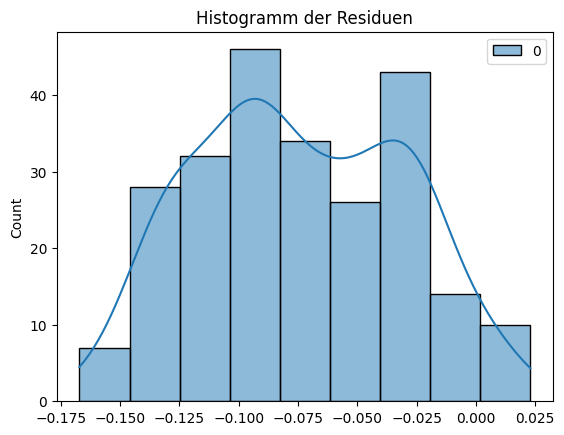

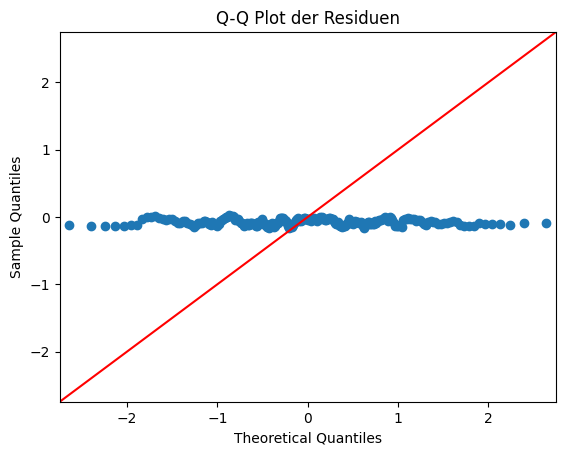

In [12]:
import seaborn as sns
import statsmodels.api as sm

# Berechne Residuen für LSTM-Modell
residuals = y_test - lstm_pred

# Histogramm der Residuen
sns.histplot(residuals, kde=True)
plt.title('Histogramm der Residuen')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot der Residuen')
plt.show()


## 2. Bland-Altman-Analyse

Die Bland-Altman-Analyse (oder Unterschiedsplot) ist ein grafisches Verfahren, um zwei Messmethoden zu vergleichen. Sie ist besonders nützlich, wenn du zwei Modelle vergleichen möchtest, um zu sehen, wie sehr ihre Vorhersagen voneinander abweichen.

Schritte:

    Plotte die Differenzen zwischen den Vorhersagen zweier Modelle gegen ihre Mittelwerte.
    Analysiere, ob die Differenzen signifikant sind oder zufällig verteilt erscheinen.

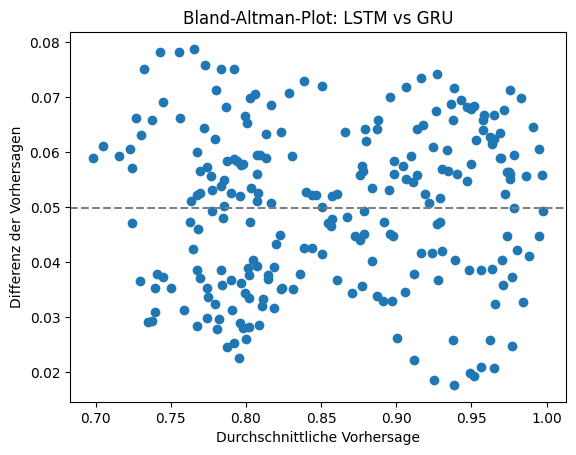

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Mittelwerte und Differenzen der Vorhersagen zweier Modelle
mean_predictions = np.mean([lstm_pred, gru_pred], axis=0)
diff_predictions = lstm_pred - gru_pred

plt.scatter(mean_predictions, diff_predictions)
plt.axhline(np.mean(diff_predictions), color='gray', linestyle='--')
plt.title('Bland-Altman-Plot: LSTM vs GRU')
plt.xlabel('Durchschnittliche Vorhersage')
plt.ylabel('Differenz der Vorhersagen')
plt.show()

## 3. Wahrscheinlichkeitsbasierte Tests (Likelihood Ratio Test)

Der Likelihood Ratio Test (LRT) vergleicht die Güte zweier Modelle auf Basis ihrer Likelihoods. Du kannst LRT verwenden, um zu testen, ob das Hinzufügen zusätzlicher Parameter in einem Modell signifikante Verbesserungen bringt.

Schritte:

    Berechne die Log-Likelihood für jedes Modell.
    Vergleiche die Likelihoods der Modelle, um zu sehen, ob eines signifikant besser passt.

In [14]:
# Berechnung der Log-Likelihood für zwei Modelle
ll_lstm = np.sum(scipy.stats.norm.logpdf(y_test, loc=lstm_pred))
ll_gru = np.sum(scipy.stats.norm.logpdf(y_test, loc=gru_pred))


# Likelihood Ratio Test
LRT_stat = -2 * (ll_lstm - ll_gru)
p_value = scipy.stats.chi2.sf(LRT_stat, df=1)  # df = Differenz der Freiheitsgrade
print(f'Likelihood Ratio Test Statistik: {LRT_stat}, P-Wert: {p_value}')

Likelihood Ratio Test Statistik: 1.3597714173578765, P-Wert: 0.24357710087901774


## 4. Shapiro-Wilk-Test (Normalitätstest)

Überprüfe mit dem Shapiro-Wilk-Test, ob die Residuen normalverteilt sind. Viele statistische Tests und Modelle gehen von normalverteilten Residuen aus. Wenn sie signifikant von der Normalverteilung abweichen, könnte dies auf systematische Fehler oder Modellmängel hinweisen.

In [15]:
from scipy.stats import shapiro

# Test für Normalität der Residuen
stat, p_value = shapiro(residuals)
print(f'Shapiro-Wilk Test Statistik: {stat}, P-Wert: {p_value}')

Shapiro-Wilk Test Statistik: 0.9772070646286011, P-Wert: 0.0006591673009097576


## 5. Cross-Validation / ANOVA

Kreuzvalidierung ist eine Methode, um die Generalisierbarkeit von Modellen zu bewerten. Bei Zeitreihendaten könnte eine Time Series Split-Kreuzvalidierung durchgeführt werden, um sicherzustellen, dass die Modelle nicht nur auf den Trainingsdaten gut abschneiden, sondern auch auf neuen Daten.

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialisiere KFold Cross-Validation
kf = KFold(n_splits=5)

# Listen zum Speichern der MSE-Werte
mse_lstm = []
mse_gru = []
mse_cnn_lstm = []

# Cross-Validation durchführen
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Trainiere und bewerte jedes Modell
    lstm_modell.fit(X_train, y_train)
    gru_modell.fit(X_train, y_train)
    cnn_lstm_modell.fit(X_train, y_train)
    
    lstm_pred = lstm_modell.predict(X_test)
    gru_pred = gru_modell.predict(X_test)
    cnn_lstm_pred = cnn_lstm_modell.predict(X_test)
    
    # MSE-Werte speichern
    mse_lstm.append(mean_squared_error(y_test, lstm_pred))
    mse_gru.append(mean_squared_error(y_test, gru_pred))
    mse_cnn_lstm.append(mean_squared_error(y_test, cnn_lstm_pred))

# ANOVA Test durchführen
anova_result = scipy.stats.f_oneway(mse_lstm, mse_gru, mse_cnn_lstm)
print('ANOVA Ergebnis:', anova_result)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0029
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0038
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0032
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0024
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.002

# Zusammenfassung der statistischen Untersuchungsmethoden:

    Residualanalyse: Identifiziert potenzielle Modellfehler und Unregelmäßigkeiten.
    Bland-Altman-Analyse: Grafischer Vergleich von Modellen.
    Likelihood Ratio Test: Vergleich der Modellanpassung durch Likelihoods.
    Shapiro-Wilk-Test: Überprüfung der Normalverteilung der Residuen.
    Cross-Validation: Beurteilung der Generalisierbarkeit des Modells.
    ANOVA und paarweiser T-Test: Vergleich der Leistung verschiedener Modelle und Tests auf signifikante Unterschiede.
    
Diese Methoden helfen, die Performance der Modelle tiefer zu analysieren und fundierte Rückschlüsse darüber zu ziehen, welches Modell am besten geeignet ist und wie es weiter verbessern werden kann.